In [ ]:
import yfinance as yf
from ta import add_all_ta_features
from ta.utils import dropna

russell = yf.download("IWV")
mom_data = add_all_ta_features(russell.copy(), open="Open", high="High", low="Low", close="Close", volume="Volume")

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/usr/local/lib/python3.7/dist-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [ ]:
data = mom_data[['Open', 'High', 'Low','Close','Volume','others_dr', 'momentum_roc','momentum_rsi']].copy()
data = dropna(data)
data

,Open,High,Low,Close,Volume,others_dr,momentum_roc,momentum_rsi
Date,,,,,,,,
2000-06-15,80.593750,81.046875,80.593750,80.890625,1400.0,-0.038617,4.459241,78.244980
2000-06-16,80.750000,80.750000,80.750000,80.750000,600.0,-0.173846,3.174286,75.939370
2000-06-19,79.968750,80.843750,79.968750,80.843750,1000.0,0.116099,3.006172,76.437839
2000-06-20,81.625000,81.625000,80.843750,81.531250,1200.0,0.850406,0.675285,79.750856
2000-06-21,80.687500,81.046875,80.687500,81.046875,2500.0,-0.594097,0.601241,72.062850
...,...,...,...,...,...,...,...,...
2022-02-04,258.390015,262.359985,257.290009,260.309998,126300.0,0.715780,-0.807833,45.437045
2022-02-07,260.920013,261.679993,258.739990,259.429993,177200.0,-0.338060,0.026992,44.391143
2022-02-08,259.290009,262.450012,258.480011,261.839996,153400.0,0.928961,2.989298,47.926361


In [ ]:
import numpy as np
import operator
import random
from deap import gp, base, creator, tools, algorithms
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
data['nextday_re']=data['others_dr'].shift(-1)
data.dropna(axis=0,how='any',inplace=True)

In [ ]:
data['roc_overbought1'] = data['momentum_roc'] > 5
data['roc_overbought2'] = data['momentum_roc'] > 6
data['roc_overbought3'] = data['momentum_roc'] > 7
data['roc_overbought4'] = data['momentum_roc'] > 8
data['roc_overbought5'] = data['momentum_roc'] > 9
data['roc_oversold1'] = data['momentum_roc'] < -6
data['roc_oversold2'] = data['momentum_roc'] < -5
data['roc_oversold3'] = data['momentum_roc'] < -4
data['roc_oversold4'] = data['momentum_roc'] < -3
data['roc_oversold5'] = data['momentum_roc'] < -2

In [ ]:
data['rsi_overbought1'] = data['momentum_rsi'] > 60
data['rsi_overbought2'] = data['momentum_rsi'] > 65
data['rsi_overbought3'] = data['momentum_rsi'] > 70
data['rsi_overbought4'] = data['momentum_rsi'] > 75
data['rsi_overbought5'] = data['momentum_rsi'] > 80
data['rsi_oversold1'] = data['momentum_rsi'] < 20
data['rsi_oversold2'] = data['momentum_rsi'] < 25
data['rsi_oversold3'] = data['momentum_rsi'] < 30
data['rsi_oversold4'] = data['momentum_rsi'] < 35
data['rsi_oversold5'] = data['momentum_rsi'] < 40

In [ ]:
#KDJ
low_list=data['Low'].rolling(window=9).min()
low_list.fillna(value=data['Low'].expanding().min(), inplace=True)
high_list = data['High'].rolling(window=9).max()
high_list.fillna(value=data['High'].expanding().max(), inplace=True)

rsv = (data['Close'] - low_list) / (high_list - low_list) * 100
data['KDJ_K'] = rsv.ewm(com=2).mean()
data['KDJ_D'] = data['KDJ_K'].ewm(com=2).mean()
data['KDJ_J'] = 3 * data['KDJ_K'] - 2 * data['KDJ_D']
data = dropna(data)

data['kdj_overbought1'] = data['KDJ_K'] > 90
data['kdj_overbought2'] = data['KDJ_D'] > 80
data['kdj_overbought3'] = data['KDJ_J'] > 100
data['kdj_oversold1'] = data['KDJ_K'] < 10
data['kdj_oversold2'] = data['KDJ_D'] < 20
data['kdj_oversold3'] = data['KDJ_J'] < 0

In [ ]:
# MACD
close = np.array( data.Close )
ndata = len(close)
m, n, T = 12, 26, 9
EMA1 = np.copy(close)
EMA2 = np.copy(close)
f1 = (m-1)/(m+1)
f2 = (n-1)/(n+1)
f3 = (T-1)/(T+1)
for i in range(1, ndata):
    EMA1[i] = EMA1[i-1]*f1 + EMA1[i]*(1-f1)
    EMA2[i] = EMA2[i-1]*f2 + EMA2[i]*(1-f2)
data['ma1'] = EMA1
data['ma2'] = EMA2
DIF = EMA1 - EMA2
data['DIF'] = DIF
DEA = np.copy(DIF)
for i in range(1, ndata):
    DEA[i] = DEA[i-1]*f3 + DEA[i]*(1-f3)
data['DEA'] = DEA
data.drop(['ma1','ma2'],axis=1,inplace=True)


data['MACD_signal_buy'] = False
data['MACD_signal_sell'] = False
macd_position = data['DIF'] > data['DEA']
data.loc[macd_position[(macd_position == True) & (macd_position.shift() == False)].index, 'MACD_signal_buy'] = True
data.loc[macd_position[(macd_position == False) & (macd_position.shift() == True)].index, 'MACD_signal_sell'] = True

In [ ]:
# import state data
from google.colab import files
uploaded = files.upload()
statedata=pd.read_csv('States.csv',parse_dates=['Date'])
statedata=statedata.set_index('Date').resample('B').ffill()
statedata=statedata['new_state']
data=pd.merge(data,statedata,on='Date')
data.dropna(axis=0,how='any',inplace=True)
data

Saving States.csv to States (1).csv


,Open,High,Low,Close,Volume,others_dr,momentum_roc,momentum_rsi,nextday_re,roc_overbought1,roc_overbought2,roc_overbought3,roc_overbought4,roc_overbought5,roc_oversold1,roc_oversold2,roc_oversold3,roc_oversold4,roc_oversold5,rsi_overbought1,rsi_overbought2,rsi_overbought3,rsi_overbought4,rsi_overbought5,rsi_oversold1,rsi_oversold2,rsi_oversold3,rsi_oversold4,rsi_oversold5,KDJ_K,KDJ_D,KDJ_J,kdj_overbought1,kdj_overbought2,kdj_overbought3,kdj_oversold1,kdj_oversold2,kdj_oversold3,DIF,DEA,MACD_signal_buy,MACD_signal_sell,new_state
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-15,80.593750,81.046875,80.593750,80.890625,1400.0,-0.038617,4.459241,78.244980,-0.173846,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,65.517241,65.517241,65.517241,False,False,False,False,False,False,0.000000,0.000000,False,False,-1
2000-06-16,80.750000,80.750000,80.750000,80.750000,600.0,-0.173846,3.174286,75.939370,0.116099,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,46.896552,54.344828,32.000000,False,False,False,False,False,False,-0.011218,-0.002244,False,False,-1
2000-06-19,79.968750,80.843750,79.968750,80.843750,1000.0,0.116099,3.006172,76.437839,0.850406,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,63.126332,58.504487,72.370020,False,False,False,False,False,False,-0.012400,-0.004275,False,False,0
2000-06-20,81.625000,81.625000,80.843750,81.531250,1200.0,0.850406,0.675285,79.750856,-0.594097,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,76.091852,65.810008,96.655541,False,False,False,False,False,False,0.041658,0.004912,True,False,0
2000-06-21,80.687500,81.046875,80.687500,81.046875,2500.0,-0.594097,0.601241,72.062850,-1.291691,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,71.870058,68.136378,79.337419,False,False,False,False,False,False,0.044897,0.012909,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16,277.140015,279.010010,277.140015,278.420013,98500.0,0.425632,2.375357,68.788072,-0.391504,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,69.846612,70.862893,67.814050,False,False,False,False,False,False,3.473145,3.476481,False,True,1
2021-11-17,278.140015,278.140015,276.980011,277.329987,79800.0,-0.391504,1.493133,64.612212,0.191108,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,66.713541,69.479776,61.181073,False,False,False,False,False,False,3.341147,3.449414,False,False,1
2021-11-18,277.989990,278.079987,275.929993,277.859985,85400.0,0.191108,1.316312,65.702442,-0.291513,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,69.310944,69.423498,69.085834,False,False,False,False,False,False,3.241932,3.407918,False,False,1


In [ ]:
# group by state
#bull = [1], bear = [-1], static = [0]
grouped=data.groupby('new_state')
bull=grouped.get_group(1)
static=grouped.get_group(0)
bear=grouped.get_group(-1)

In [ ]:
pset = gp.PrimitiveSetTyped('main', [bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,
                    bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,                 
                    bool,bool,bool,bool,bool,bool,bool,bool], float)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)

def if_then_else(input1, input2):
    if input1 and input2:
        return 1.0
    if not input1 and not input2:
        return -1.0
    return 0.0
pset.addPrimitive(if_then_else, [bool, bool], float)

In [ ]:
creator.create('FitnessMax',base.Fitness,weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=3, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population',tools.initRepeat,list,toolbox.individual)
toolbox.register('compile',gp.compile, pset=pset)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [ ]:
def test_roc(state):
  x=state.copy()
  train=x[(x.index.year>=2000)&(x.index.year<2018)]
  test=x[x.index.year>=2018]

  x1=train['roc_overbought1'] 
  x2=train['roc_overbought2'] 
  x3=train['roc_overbought3'] 
  x4=train['roc_overbought4'] 
  x5=train['roc_overbought5'] 
  x6=train['roc_oversold1'] 
  x7=train['roc_oversold2'] 
  x8=train['roc_oversold3'] 
  x9=train['roc_oversold4'] 
  x10=train['roc_oversold5']
  xx1=test['roc_overbought1'] 
  xx2=test['roc_overbought2'] 
  xx3=test['roc_overbought3'] 
  xx4=test['roc_overbought4'] 
  xx5=test['roc_overbought5'] 
  xx6=test['roc_oversold1'] 
  xx7=test['roc_oversold2'] 
  xx8=test['roc_oversold3'] 
  xx9=test['roc_oversold4'] 
  xx10=test['roc_oversold5'] 
  
  x11=train['rsi_overbought1'] 
  x12=train['rsi_overbought2'] 
  x13=train['rsi_overbought3'] 
  x14=train['rsi_overbought4'] 
  x15=train['rsi_overbought5'] 
  x16=train['rsi_oversold1'] 
  x17=train['rsi_oversold2'] 
  x18=train['rsi_oversold3'] 
  x19=train['rsi_oversold4'] 
  x20=train['rsi_oversold5'] 
  xx11=test['rsi_overbought1'] 
  xx12=test['rsi_overbought2'] 
  xx13=test['rsi_overbought3'] 
  xx14=test['rsi_overbought4'] 
  xx15=test['rsi_overbought5'] 
  xx16=test['rsi_oversold1'] 
  xx17=test['rsi_oversold2'] 
  xx18=test['rsi_oversold3'] 
  xx19=test['rsi_oversold4'] 
  xx20=test['rsi_oversold5'] 

  x21=train['kdj_overbought1'] 
  x22=train['kdj_overbought2'] 
  x23=train['kdj_overbought3'] 
  x24=train['kdj_oversold1'] 
  x25=train['kdj_oversold2'] 
  x26=train['kdj_oversold3'] 
  xx21=test['kdj_overbought1'] 
  xx22=test['kdj_overbought2'] 
  xx23=test['kdj_overbought3'] 
  xx24=test['kdj_oversold1'] 
  xx25=test['kdj_oversold2'] 
  xx26=test['kdj_oversold3'] 

  x27=train['MACD_signal_buy'] 
  x28=train['MACD_signal_sell'] 
  xx27=test['MACD_signal_buy'] 
  xx28=test['MACD_signal_sell'] 

  y=train['nextday_re']/100
  yy=test['nextday_re']/100
  time=list(test.index)
#****************************************************************************************************#
  def fit_evaluation(individual):
    func = toolbox.compile(expr=individual)
    cum = 1
    for i in range(len(x11)):
        state = func(x1[i],x2[i],x3[i],x4[i],x5[i],x6[i],x7[i],x8[i],x9[i],x10[i],
            x11[i],x12[i],x13[i],x14[i],x15[i],x16[i],x17[i],x18[i],x19[i],x20[i],
            x21[i],x22[i],x23[i],x24[i],x25[i],x26[i],x27[i],x28[i])
        if int(state) == 0:   # buy bond
            re = 0.03/252
        if int(state) == 1:     # long Russell 3000
            re = y[i]
        if int(state) == -1:
            re = -y[i]     # short Russell 3000
        cum = cum * (1+re)
    return (cum,)

  toolbox.register('evaluate',fit_evaluation)
  toolbox.register('select',tools.selTournament,tournsize = 3)
  toolbox.register('mate',gp.cxOnePoint)           
  toolbox.register('expr_mut',gp.genFull,pset=pset,min_ = 3,max_ = 5)
  toolbox.register('mutate',gp.mutUniform,expr=toolbox.expr_mut,pset=pset)   
  toolbox.decorate('mate',gp.staticLimit(key=operator.attrgetter('height'),max_value=17))   
  toolbox.decorate('mutate',gp.staticLimit(key=operator.attrgetter('height'),max_value=17)) 
#********************************************************************************************************#
  cxpb = 0.6      # probability of crossover operation
  mutpb = 0.2     # probability of mutation operation
  ngen = 100       # generations
  popSize = 100   # population size
  random.seed(666)

  pop = toolbox.population(n=popSize)
  hof = tools.HallOfFame(1)

  stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
  stats_size = tools.Statistics(len)
  mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
  mstats.register("avg", np.mean)
  mstats.register("std", np.std)
  mstats.register("min", np.min)
  mstats.register("max", np.max)

  pop, log = algorithms.eaSimple(pop, toolbox, cxpb, mutpb, ngen, stats=mstats, halloffame=hof, verbose=True)
#***************************************SHOW TEST RESULT****************************************#  
  func = toolbox.compile(expr = hof.items[0])
  retu = []
  for i in range(len(xx11)):
    state = func(xx1[i],xx2[i],xx3[i],xx4[i],xx5[i],xx6[i],xx7[i],xx8[i],xx9[i],xx10[i],
           xx11[i],xx12[i],xx13[i],xx14[i],xx15[i],xx16[i],xx17[i],xx18[i],xx19[i],xx20[i],
           xx21[i],xx22[i],xx23[i],xx24[i],xx25[i],xx26[i],xx27[i],xx28[i])
    if int(state) == 0:
        re = 0.03/252
    if int(state) == 1:
        re = yy[i]
    if int(state) == -1:
        re = -yy[i]
    retu.append(re)  
#*************************************SHOW STRATEGY**********************************************#
  strategy=[]
  for i in range(len(xx11)):
    state = func(xx1[i],xx2[i],xx3[i],xx4[i],xx5[i],xx6[i],xx7[i],xx8[i],xx9[i],xx10[i],
           xx11[i],xx12[i],xx13[i],xx14[i],xx15[i],xx16[i],xx17[i],xx18[i],xx19[i],xx20[i],
           xx21[i],xx22[i],xx23[i],xx24[i],xx25[i],xx26[i],xx27[i],xx28[i])
    strategy.append(state)
  
  return time,retu,strategy 

In [ ]:
data['retu_regime']=''
data['stra_regime']=''
bearresult=test_roc(bear)
for i in range(len(bearresult[0])):
  data.loc[bearresult[0][i],'retu_regime']=bearresult[1][i]
  data.loc[bearresult[0][i],'stra_regime']=bearresult[2][i]

staticresult=test_roc(static)
for i in range(len(staticresult[0])):
  data.loc[staticresult[0][i],'retu_regime']=staticresult[1][i]
  data.loc[staticresult[0][i],'stra_regime']=staticresult[2][i]

bullresult=test_roc(bull)
for i in range(len(bullresult[0])):
  data.loc[bullresult[0][i],'retu_regime']=bullresult[1][i]
  data.loc[bullresult[0][i],'stra_regime']=bullresult[2][i]


   	      	                        fitness                         	                      size                     
   	      	--------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std     	avg  	gen	max	min	nevals	std    
0  	100   	1.39611	0  	5.10168	0.153401	100   	0.989136	18.73	0  	54 	7  	100   	9.60922
1  	72    	2.14262	1  	5.10168	0.216259	72    	1.08462 	20.04	1  	75 	6  	72    	11.9699
2  	62    	2.74643	2  	5.10168	0.64364 	62    	0.982557	21.03	2  	76 	5  	62    	13.2019
3  	70    	3.16305	3  	6.05144	0.831584	70    	1.04254 	22.24	3  	75 	5  	70    	13.8023
4  	62    	3.55338	4  	6.05144	0.219051	62    	0.964084	23.82	4  	77 	5  	62    	14.7441
5  	75    	3.6114 	5  	6.05144	0.690645	75    	1.30562 	26.63	5  	127	5  	75    	18.8619
6  	69    	4.04762	6  	6.05144	0.318388	69    	1.30582 	32.59	6  	113	5  	69    	21.5607
7  	63    	4.73018	7  	6.05144	1.24834 	63    	1.04802 	

In [ ]:
data['retu_total']=''
data['stra_total']=''
totalresult=test_roc(data)
for i in range(len(totalresult[0])):
  data.loc[totalresult[0][i],'retu_total']=totalresult[1][i]
  data.loc[totalresult[0][i],'stra_total']=totalresult[2][i]

   	      	                        fitness                         	                      size                     
   	      	--------------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min     	nevals	std     	avg  	gen	max	min	nevals	std    
0  	100   	1.22094	0  	3.50805	0.142632	100   	0.801248	18.73	0  	54 	7  	100   	9.60922
1  	70    	1.86337	1  	4.30902	0.28197 	70    	0.763848	21   	1  	63 	6  	70    	12.3887
2  	65    	2.17329	2  	3.57344	0.204525	65    	0.695149	21.83	2  	78 	8  	65    	14.4007
3  	69    	2.44119	3  	5.608  	0.792085	69    	0.698473	21.67	3  	81 	7  	69    	13.5315
4  	71    	2.43249	4  	4.51024	0.292781	71    	0.806119	20.89	4  	75 	6  	71    	12.2629
5  	81    	2.41939	5  	4.51024	0.362734	81    	0.976916	28.46	5  	78 	6  	81    	15.6764
6  	83    	2.5261 	6  	4.51024	0.327065	83    	0.949598	31.03	6  	88 	6  	83    	19.2252
7  	71    	2.8959 	7  	4.48158	0.427036	71    	0.819664	

In [ ]:
data_test=data[data.index.year>=2018]
data_test

,Open,High,Low,Close,Volume,others_dr,momentum_roc,momentum_rsi,nextday_re,roc_overbought1,roc_overbought2,roc_overbought3,roc_overbought4,roc_overbought5,roc_oversold1,roc_oversold2,roc_oversold3,roc_oversold4,roc_oversold5,rsi_overbought1,rsi_overbought2,rsi_overbought3,rsi_overbought4,rsi_overbought5,rsi_oversold1,rsi_oversold2,rsi_oversold3,rsi_oversold4,rsi_oversold5,KDJ_K,KDJ_D,KDJ_J,kdj_overbought1,kdj_overbought2,kdj_overbought3,kdj_oversold1,kdj_oversold2,kdj_oversold3,DIF,DEA,MACD_signal_buy,MACD_signal_sell,new_state,retu_regime,stra_regime,retu_total,stra_total
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,158.710007,159.369995,158.500000,159.369995,409200.0,0.758675,0.988529,66.548219,0.527083,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,49.949904,53.059498,43.730716,False,False,False,False,False,False,1.153724,1.261779,False,False,0,0.000119,0.0,0.000119,0.0
2018-01-03,159.470001,160.309998,159.470001,160.210007,248200.0,0.527083,1.999108,70.380432,0.418200,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,65.118254,57.079083,81.196597,False,False,False,False,False,False,1.214608,1.252345,False,False,0,0.000119,0.0,-0.004182,-1.0
2018-01-04,160.699997,161.130005,160.690002,160.880005,382400.0,0.418200,1.533612,73.033943,0.584288,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,73.986125,62.714764,96.528847,False,False,False,False,False,False,1.301914,1.262258,True,False,0,-0.005843,-1.0,-0.005843,-1.0
2018-01-05,161.500000,161.899994,161.080002,161.820007,256000.0,0.584288,1.416401,76.248839,0.197746,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,81.953927,69.127818,107.606146,False,False,True,False,False,False,1.430465,1.295900,False,False,0,0.000119,0.0,0.001977,1.0
2018-01-08,161.830002,162.259995,161.479996,162.139999,792700.0,0.197746,2.026177,77.243445,0.172690,False,False,False,False,False,False,False,False,False,False,True,True,True,True,False,False,False,False,False,False,87.005467,75.087035,110.842333,False,False,True,False,False,False,1.540407,1.344801,False,False,1,0.001727,1.0,0.001727,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-16,277.140015,279.010010,277.140015,278.420013,98500.0,0.425632,2.375357,68.788072,-0.391504,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,69.846612,70.862893,67.814050,False,False,False,False,False,False,3.473145,3.476481,False,True,1,-0.003915,1.0,-0.003915,1.0
2021-11-17,278.140015,278.140015,276.980011,277.329987,79800.0,-0.391504,1.493133,64.612212,0.191108,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,66.713541,69.479776,61.181073,False,False,False,False,False,False,3.341147,3.449414,False,False,1,0.000119,0.0,0.000119,0.0
2021-11-18,277.989990,278.079987,275.929993,277.859985,85400.0,0.191108,1.316312,65.702442,-0.291513,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,69.310944,69.423498,69.085834,False,False,False,False,False,False,3.241932,3.407918,False,False,1,0.000119,0.0,0.000119,0.0


In [ ]:
#cum return of total strategy
cumre_total=[1+data_test.retu_total[0]]
for i in range(1,len(data_test.retu_total)):
  cumre=cumre_total[-1]*(1+data_test.retu_total[i])
  cumre_total.append(cumre)

In [ ]:
#cum return of regime strategy
cumre_regime=[1+data_test.retu_regime[0]]
for i in range(1,len(data_test.retu_regime)):
  cumre=cumre_regime[-1]*(1+data_test.retu_regime[i])
  cumre_regime.append(cumre)

In [ ]:
#buy and hold
buyandhold=[1+data_test.nextday_re[0]/100]
for i in range(1,len(data_test.nextday_re)):
  cumre=buyandhold[-1]*(1+data_test.nextday_re[i]/100)
  buyandhold.append(cumre)

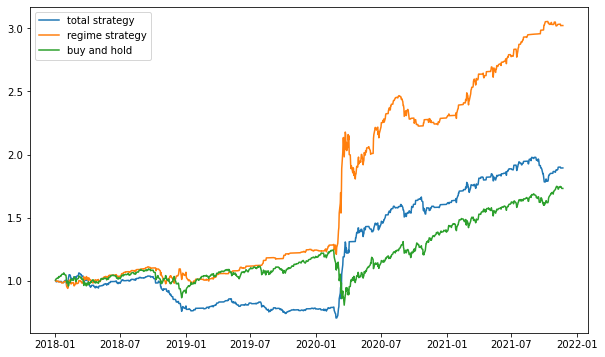

In [ ]:
time=data_test.index
plt.figure(figsize=(10,6))
plt.plot(time,cumre_total,label='total strategy')
plt.plot(time,cumre_regime,label='regime strategy')
plt.plot(time,buyandhold,label='buy and hold')
plt.legend(loc = 'best')

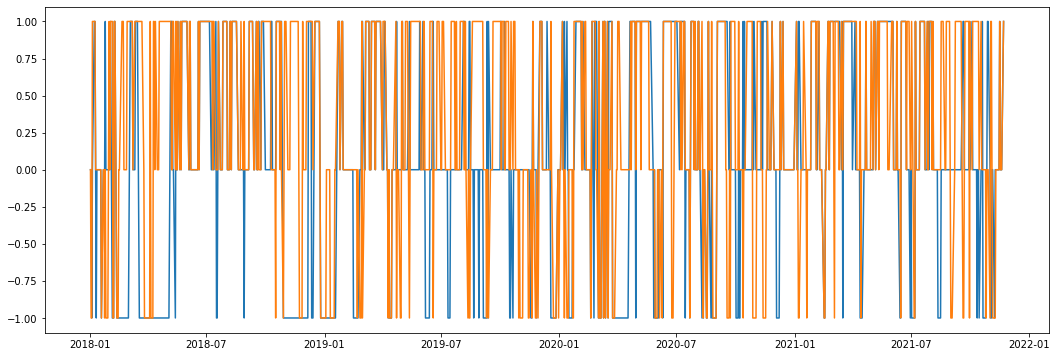

In [ ]:
strategy_regime=data_test.stra_regime
strategy_total=data_test.stra_total
plt.figure(figsize=(18,6))
plt.plot(time,strategy_regime,label='regime strategy')
plt.plot(time,strategy_total,label='total strategy')